# Paper Reproduction
## Khaidem, Luckyson, Snehanshu Saha, and Sudeepa Roy Dey. "Predicting the direction of stock market prices using random forest." arXiv preprint arXiv:1605.00003 (2016). [paper](https://arxiv.org/abs/1605.00003)
#### Original Source Code by [José Martínez Heras](https://www.linkedin.com/in/josemartinezheras/)
#### Modifications made by Victor Suhendra and Rohan Pamidimukkla

## Goal of the project
Reproduce the results from the paper "Predicting the direction of stock market prices using random forest."

## Import Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# Make the default figures a bit bigger
plt.rcParams['figure.figsize'] = (7,4.5) 

import numpy as np
import random


#https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py
import pandas_techinal_indicators as ta 

import pandas as pd
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
def get_exp_preprocessing(df, alpha=0.9):
    edata = df.ewm(alpha=alpha).mean()    
    return edata

def feature_extraction(data):
    for x in [5, 14, 26, 44, 66]:
        data = ta.relative_strength_index(data, n=x)
        data = ta.stochastic_oscillator_d(data, n=x)
        data = ta.accumulation_distribution(data, n=x)
        data = ta.average_true_range(data, n=x)
        data = ta.momentum(data, n=x)
        data = ta.money_flow_index(data, n=x)
        data = ta.rate_of_change(data, n=x)
        data = ta.on_balance_volume(data, n=x)
        data = ta.commodity_channel_index(data, n=x)
        data = ta.ease_of_movement(data, n=x)
        data = ta.trix(data, n=x)
        data = ta.vortex_indicator(data, n=x)
    
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema14'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()
        
    #Williams %R is missing
    data = ta.macd(data, n_fast=12, n_slow=26)
    
    del(data['Open'])
    del(data['High'])
    del(data['Low'])
    del(data['Volume'])
    
    return data
   
def compute_prediction_int(df, n):
    pred = (df.shift(-n)['Close'] >= df['Close'])
    pred = pred.iloc[:-n]
    return pred.astype(int)

def prepare_data(df, horizon):
    data = feature_extraction(df).dropna().iloc[:-horizon]
    data['pred'] = compute_prediction_int(data, n=horizon)
    del(data['Close'])
    return data.dropna()

In [3]:
def random_forest(data):
    data = get_exp_preprocessing(data)
    data = prepare_data(data, 10)
    y = data['pred']
    features = [x for x in data.columns if x not in ['gain', 'pred']]
    X = data[features]
    train_size = 2*len(X) // 3

    X_train = X[:train_size]
    X_test = X[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]
    
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=65)
    rf.fit(X_train, y_train.values.ravel());
    pred = rf.predict(X_test)
    precision = precision_score(y_pred=pred, y_true=y_test)
    recall = recall_score(y_pred=pred, y_true=y_test)
    f1 = f1_score(y_pred=pred, y_true=y_test)
    accuracy = accuracy_score(y_pred=pred, y_true=y_test)
    confusion = confusion_matrix(y_pred=pred, y_true=y_test)
    
    return(precision, recall, f1, accuracy)
    
    
def random_forest_leakage(data):
    data = get_exp_preprocessing(data)
    data = prepare_data(data, 10)
    y = data['pred']
    features = [x for x in data.columns if x not in ['gain', 'pred']]
    X = data[features]

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 2*len(X) // 3)
    
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=65)
    rf.fit(X_train, y_train.values.ravel());
    pred = rf.predict(X_test)
    precision = precision_score(y_pred=pred, y_true=y_test)
    recall = recall_score(y_pred=pred, y_true=y_test)
    f1 = f1_score(y_pred=pred, y_true=y_test)
    accuracy = accuracy_score(y_pred=pred, y_true=y_test)
    confusion = confusion_matrix(y_pred=pred, y_true=y_test)
    
    return(precision, recall, f1, accuracy)

In [4]:
def normal_perturbation(data, param1, param2, binom_prob):
    for i in range(data.shape[0]):
        x =  np.random.normal(param1, param2)
        if np.random.binomial(1,binom_prob) == 1:
            for j in range(4):
                data.iloc[i, j] = data.iloc[i, j] + x
    return(data)

def exponential_perturbation(data, param1, binom_prob):
    for i in range(data.shape[0]):
        x =  np.random.exponential(param1)
        if np.random.binomial(1,binom_prob) == 1:
            for j in range(4):
                data.iloc[i, j] = data.iloc[i, j] + x
    return(data)

def uniform_perturbation(data, param1, param2, binom_prob):
    for i in range(data.shape[0]):
        x =  np.random.uniform(param1, param2)
        if np.random.binomial(1,binom_prob) == 1:
            for j in range(4):
                data.iloc[i, j] = data.iloc[i, j] + x
    return(data)

In [5]:
aapl = pd.read_csv('AAPL.csv')
del(aapl['Date'])
del(aapl['Adj Close'])
random_forest(aapl)
#(precision, recall, f1, accuracy)

(0.6733870967741935,
 0.5880281690140845,
 0.6278195488721804,
 0.5580357142857143)

In [6]:
aapl = pd.read_csv('AAPL.csv')
del(aapl['Date'])
del(aapl['Adj Close'])
random_forest_leakage(aapl)
#(precision, recall, f1, accuracy)

(0.8412698412698413,
 0.9498207885304659,
 0.8922558922558923,
 0.8571428571428571)

0.031249999999999955


0.0647321428571428

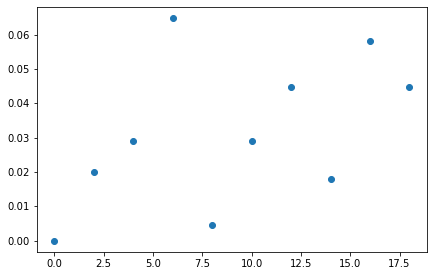

In [7]:
aapl_normal = []
aapl = pd.read_csv('AAPL.csv')
del(aapl['Date'])
del(aapl['Adj Close'])
for param in range(0,20,2):
    data2 = normal_perturbation(aapl, 0, param, 0.1).copy()
    aapl_normal.append(random_forest(data2)[3])
aapl_normal = aapl_normal - aapl_normal[0]
fig, ax = plt.subplots()
ax.scatter([i for i in range(0,20,2)], aapl_normal)
print(sum(aapl_normal)/ len(aapl_normal))
max(aapl_normal)

0.031026785714285698


0.0714285714285714

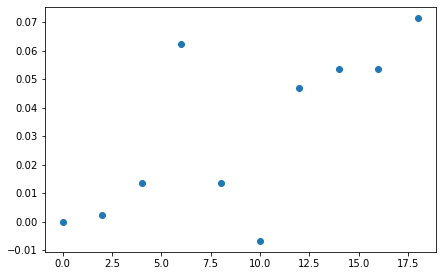

In [8]:
aapl_exponential = []
aapl = pd.read_csv('AAPL.csv')
del(aapl['Date'])
del(aapl['Adj Close'])
for param in range(0,20,2):
    data2 = exponential_perturbation(aapl, param, 0.1).copy()
    aapl_exponential.append(random_forest(data2)[3])
aapl_exponential = aapl_exponential - aapl_exponential[0]
fig, ax = plt.subplots()
ax.scatter([i for i in range(0,20,2)], aapl_exponential)
print(sum(aapl_exponential)/ len(aapl_exponential))
max(aapl_exponential)

-0.021428571428571463


0.017857142857142794

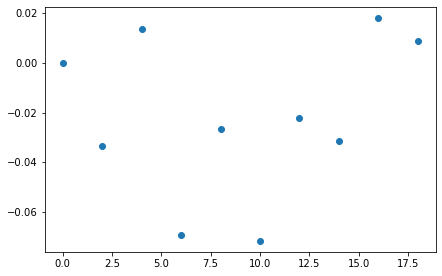

In [9]:
aapl_uniform = []
aapl = pd.read_csv('AAPL.csv')
del(aapl['Date'])
del(aapl['Adj Close'])
for param in range(0,20,2):
    data2 = uniform_perturbation(aapl, 0, param, 0.1).copy()
    aapl_uniform.append(random_forest(data2)[3])
aapl_uniform = aapl_uniform - aapl_uniform[0]
fig, ax = plt.subplots()
ax.scatter([i for i in range(0,20,2)], aapl_uniform)
print(sum(aapl_uniform)/ len(aapl_uniform))
max(aapl_uniform)

0.02656249999999998


0.06919642857142849

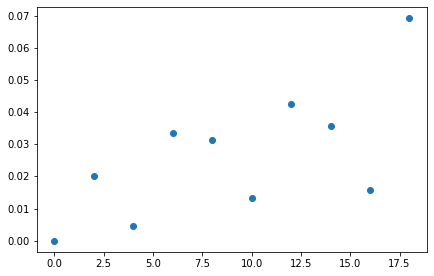

In [10]:
amazon_normal = []
amazon = pd.read_csv("AMZN.csv")
del(amazon['Date'])
del(amazon['Adj Close'])
for param in range(0,20,2):
    data2 = normal_perturbation(amazon, 0, param, 0.1).copy()
    amazon_normal.append(random_forest(data2)[3])
amazon_normal = amazon_normal - amazon_normal[0]
fig, ax = plt.subplots()
ax.scatter([i for i in range(0,20,2)], amazon_normal)
print(sum(amazon_normal)/ len(amazon_normal))
max(amazon_normal)

0.01941964285714287


0.0535714285714286

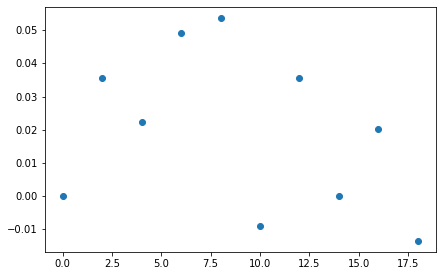

In [11]:
amazon_exponential = []
amazon = pd.read_csv("AMZN.csv")
del(amazon['Date'])
del(amazon['Adj Close'])
for param in range(0,20,2):
    data2 = exponential_perturbation(amazon, param, 0.1).copy()
    amazon_exponential.append(random_forest(data2)[3])
amazon_exponential = amazon_exponential - amazon_exponential[0]
fig, ax = plt.subplots()
ax.scatter([i for i in range(0,20,2)], amazon_exponential)
print(sum(amazon_exponential)/ len(amazon_exponential))
max(amazon_exponential)

-0.001785714285714235


0.049107142857142905

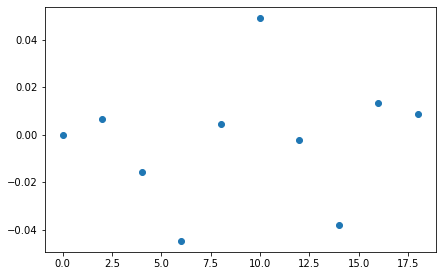

In [12]:
amazon_uniform = []
amazon = pd.read_csv("AMZN.csv")
del(amazon['Date'])
del(amazon['Adj Close'])
for param in range(0,20,2):
    data2 = uniform_perturbation(amazon, 0, param, 0.1).copy()
    amazon_uniform.append(random_forest(data2)[3])
amazon_uniform = amazon_uniform - amazon_uniform[0]
fig, ax = plt.subplots()
ax.scatter([i for i in range(0,20,2)], amazon_uniform)
print(sum(amazon_uniform)/ len(amazon_uniform))
max(amazon_uniform)

0.008035714285714235


0.033482142857142794

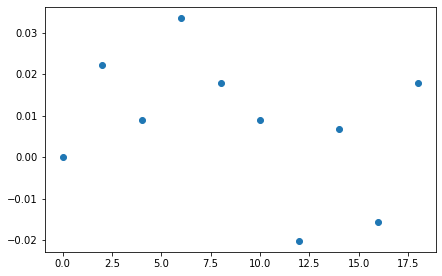

In [13]:
microsoft_normal = []
microsoft = pd.read_csv("MSFT.csv")
del(microsoft['Date'])
del(microsoft['Adj Close'])
for param in range(0,20,2):
    data2 = normal_perturbation(microsoft, 0, param, 0.1).copy()
    microsoft_normal.append(random_forest(data2)[3])
microsoft_normal = microsoft_normal - microsoft_normal[0]
fig, ax = plt.subplots()
ax.scatter([i for i in range(0,20,2)], microsoft_normal)
print(sum(microsoft_normal)/ len(microsoft_normal))
max(microsoft_normal)

0.020982142857142873


0.0736607142857143

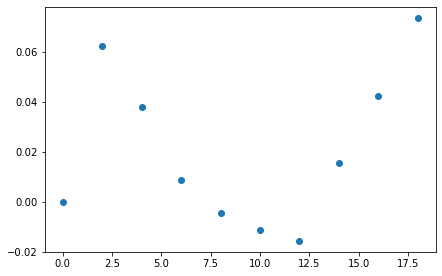

In [14]:
microsoft_exponential = []
microsoft = pd.read_csv("MSFT.csv")
del(microsoft['Date'])
del(microsoft['Adj Close'])
for param in range(0,20,2):
    data2 = exponential_perturbation(microsoft, param, 0.1).copy()
    microsoft_exponential.append(random_forest(data2)[3])
microsoft_exponential = microsoft_exponential - microsoft_exponential[0]
fig, ax = plt.subplots()
ax.scatter([i for i in range(0,20,2)], microsoft_exponential)
print(sum(microsoft_exponential)/ len(microsoft_exponential))
max(microsoft_exponential)

-0.01808035714285715


0.008928571428571397

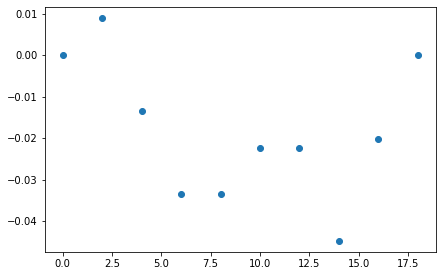

In [15]:
microsoft_uniform = []
microsoft = pd.read_csv("MSFT.csv")
del(microsoft['Date'])
del(microsoft['Adj Close'])
for param in range(0,20,2):
    data2 = uniform_perturbation(microsoft, 0, param, 0.1).copy()
    microsoft_uniform.append(random_forest(data2)[3])
microsoft_uniform = microsoft_uniform - microsoft_uniform[0]
fig, ax = plt.subplots()
ax.scatter([i for i in range(0,20,2)], microsoft_uniform)
print(sum(microsoft_uniform)/ len(microsoft_uniform))
max(microsoft_uniform)